### 1. LSTM을 이용한 로이터 뉴스 카테고리 분류하기

In [2]:
import tensorflow
tensorflow.__version__

'2.2.0'

In [3]:
# 로이터 뉴스 데이터셋 불러오기
from keras.datasets import reuters

In [4]:
# 불러온 데이터를 학습셋과 테스트셋으로 나누기
(X_train, Y_train), (X_test, Y_test) = reuters.load_data(num_words=1000, test_split=0.2)

c:\users\msi\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\datasets\reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
c:\users\msi\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\datasets\reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


test_split 인자를 통해 20%를 테스트셋으로 사용

In [5]:
# 데이터 확인 후 출력
import numpy as np
category = np.max(Y_train) + 1
print(category, '카테고리')
print(len(X_train), '학습용 뉴스 기사')
print(len(X_test), '테스트용 뉴스 기사')


46 카테고리
8982 학습용 뉴스 기사
2246 테스트용 뉴스 기사


In [6]:
"""
단어를 그대로 사용하지 않고 숫자로 변환한 다음 힉습한다.
여기서는 데이터 안에서 해당 단어가 몇 번이나 나타나는지 세어 빈도에 따라 번호를 붙였습니다.
기사 안의 모든 단어를 다 사용하는 것은 비효율적이므로 빈도가 높은 단어만 불러와 사용한다.
이때 사용하는 인자가 바로 테스트셋과 학습셋으로 나눌 때 함께 적용했던 num_word=1000이다.
빈도가 1~1,000에 해당하는 단어만 선택해서 불러온다.
"""
print(X_train[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 2, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 2, 2, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 2, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [7]:
# 3, 4가 가장 많은 레이블을 차지하는 것을 확인할 수 있다.
unique_elements, counts_elements = np.unique(Y_train, return_counts=True)
print("각 레이블에 대한 빈도수:")
print(np.asarray((unique_elements, counts_elements)))
# label_cnt=dict(zip(unique_elements, counts_elements))
# 아래의 출력 결과가 보기 불편하여 병렬로 보고싶다면 위의 label_cnt를 출력

각 레이블에 대한 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [9]:
"""
각 기사의 단어 수가 제각각 다르므로 이를 동일하게 맞춰야 한다.
이때는 다음과 같이 데이터 전처리 함수 sequence()를 이용한다.
maxlen=100은 단어 수를 100개로 맞춘다.
만일 입력된 기사의 단어 수가 100보다 크면 100개째 단어만 선택하고 나머지는 버립니다.
100에서 모자랄 때는 모자라는 부분을 모두 0으로 채웁니다.
"""
from keras.preprocessing import sequence
  
# 데이터 전처리
x_train = sequence.pad_sequences(X_train, maxlen=100)
x_test = sequence.pad_sequences(X_test, maxlen=100)

In [10]:
#  y 데이터에 원-핫 인코딩 처리를 하여 데이터 전처리 과정을 마친다.
# 데이터 전처리
y_train = to_categorical(Y_train)
y_test = to_categorical(Y_test)

* Embedding 층은 데이터 전처리 과정을 통해 입력된 값을 받아 다음 층이 알아들을 수 있는 형태로 변환하는 역할
* Embedding('불러온 단어의 총 개수', '기사당 단어 수') 형식
<br>
<br>
* LSTM은 앞서 설명했듯이 RNN에서 기억 값에 대한 가중치를 제어하며, LSTM(기사당 단어 수, 기타 옵션)의 형식으로 적용
* LSTM의 활성화 함수로는 tanh를 사용
<br>
<br>
* 46개의 카테고리를 분류해야하므로, 출력층에서는 46개의 뉴런을 사용

In [11]:
# 모델의 설정
model = Sequential()
model.add(Embedding(1000, 100))
model.add(LSTM(100, activation='tanh'))
model.add(Dense(46, activation='softmax'))

* 검증 데이터 손실(val_loss)이 증가하면, 과적합 징후므로 검증 데이터 손실이 4회 증가하면 학습을 조기 종료(Early Stopping)한다.
* ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장한다.

In [12]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

* 다중 클래스 분류(Multi-Class Classification) 문제이므로 손실 함수로는 categorical_crossentropy를 사용한다.
* categorical_crossentropy는 모델의 예측값과 실제값에 대해서 두 확률 분포 사이의 거리를 최소화하도록 훈련한다.

In [13]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

* 모델을 학습합니다. validation_data로 X_test와 y_test를 사용합니다.
* val_loss가 줄어들다가 증가하는 상황이 오면 과적합(overfitting)으로 판단하기 위함입니다.

In [16]:
history = model.fit(x_train, y_train, batch_size=128, epochs=30, callbacks=[es, mc], validation_data=(x_test, y_test))

Epoch 1/30
70/71 [============================>.] - ETA: 0s - loss: 2.1233 - acc: 0.4604
Epoch 00001: val_acc improved from -inf to 0.48798, saving model to best_model.h5
71/71 [==============================] - 7s 100ms/step - loss: 2.1227 - acc: 0.4606 - val_loss: 2.0255 - val_acc: 0.4880
Epoch 2/30
70/71 [============================>.] - ETA: 0s - loss: 1.9029 - acc: 0.5040
Epoch 00002: val_acc improved from 0.48798 to 0.51024, saving model to best_model.h5
71/71 [==============================] - 7s 95ms/step - loss: 1.9022 - acc: 0.5039 - val_loss: 1.8211 - val_acc: 0.5102
Epoch 3/30
70/71 [============================>.] - ETA: 0s - loss: 1.7326 - acc: 0.5484
Epoch 00003: val_acc improved from 0.51024 to 0.54987, saving model to best_model.h5
71/71 [==============================] - 7s 96ms/step - loss: 1.7332 - acc: 0.5485 - val_loss: 1.7464 - val_acc: 0.5499
Epoch 4/30
70/71 [============================>.] - ETA: 0s - loss: 1.6707 - acc: 0.5708
Epoch 00004: val_acc improved f

In [17]:
# 테스트 정확도 출력
print("\n Test Accuracy: %.4f" % (model.evaluate(x_test, y_test)[1]))

71/71 [==============================] - 1s 12ms/step - loss: 1.2720 - acc: 0.6915

 Test Accuracy: 0.6915


In [18]:
# 테스트셋의 오차
y_vloss = history.history['val_loss']
  
# 학습셋의 오차
y_loss = history.history['loss']

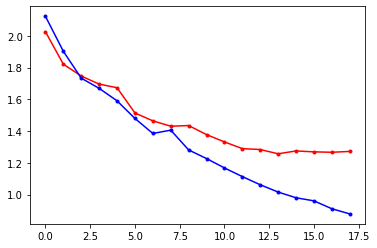

In [22]:
# 그래프로 표현
import matplotlib.pyplot as plt

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')